In [22]:
!git clone https://github.com/PhonePe/pulse.git
# Step 1: Clone the PhonePe Pulse GitHub Repository

fatal: destination path 'pulse' already exists and is not an empty directory.


In [23]:
#Step 2: Parse the JSON Data Again
import os, json
import pandas as pd

# Base path after cloning
base_path = "pulse/data/aggregated/transaction/country/india/state/"
records = []

for state in os.listdir(base_path):
    for year in os.listdir(os.path.join(base_path, state)):
        for qf in os.listdir(os.path.join(base_path, state, year)):
            file_path = os.path.join(base_path, state, year, qf)
            with open(file_path) as f:
                try:
                    content = json.load(f)["data"]["transactionData"]
                    for item in content:
                        records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "type": item["name"],
                            "count": item["paymentInstruments"][0]["count"],
                            "amount": item["paymentInstruments"][0]["amount"]
                        })
                except:
                    pass

df_txn = pd.DataFrame(records)
df_txn.head()


,state,year,quarter,type,count,amount
0,Lakshadweep,2023,3,Peer-to-peer payments,20220,77301147.0
1,Lakshadweep,2023,3,Merchant payments,14902,12027729.0
2,Lakshadweep,2023,3,Recharge & bill payments,8577,5093309.0
3,Lakshadweep,2023,3,Financial Services,16,12540.0
4,Lakshadweep,2023,3,Others,42,92336.0


In [24]:
#Step 3: Create SQL Database & Tables
import sqlite3

# Create a new SQLite database
conn = sqlite3.connect("phonepe_pulse.db")

# Save dataframe to SQL table
df_txn.to_sql("aggregated_transaction", conn, if_exists="replace", index=False)

# Show saved table names (for verification)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables


,name
0,aggregated_user
1,map_transaction
2,aggregated_transaction


In [25]:
 #Query 1: Top 5 States by Total Transaction Amount
query1 = """
SELECT state, SUM(amount) AS total_amount
FROM aggregated_transaction
GROUP BY state
ORDER BY total_amount DESC
LIMIT 5;
"""
top_states = pd.read_sql(query1, conn)
top_states


,state,total_amount
0,Telangana,4.165596e+13
1,Karnataka,4.067872e+13
2,Maharashtra,4.037420e+13
3,Andhra Pradesh,3.466908e+13
4,Uttar Pradesh,2.688521e+13


In [26]:
#Query 2: Total Transaction Count per Year
query2 = """
SELECT year, SUM(count) AS total_transactions
FROM aggregated_transaction
GROUP BY year
ORDER BY year;
"""
yearly_trend = pd.read_sql(query2, conn)
yearly_trend


,year,total_transactions
0,2018,1080202410
1,2019,4079827215
2,2020,7973974741
3,2021,19288429220
4,2022,39301293734
5,2023,64257054687
6,2024,99303434867


/tmp/ipython-input-27-1051447649.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, y="state", x="total_amount", palette="Blues_d")


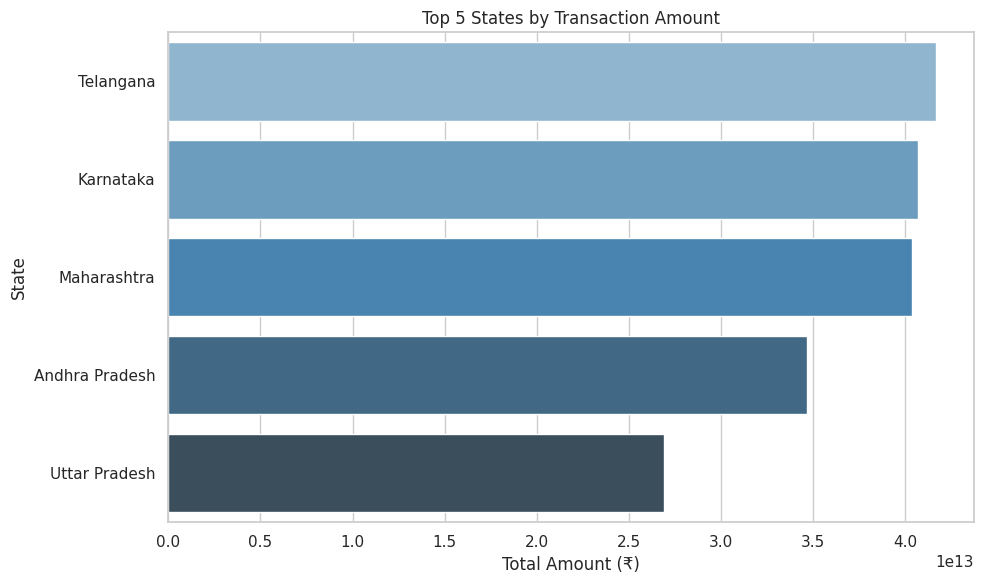

In [27]:
# Bar Chart – Top 5 States by Transaction Amount
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Plot horizontal bar chart
sns.barplot(data=top_states, y="state", x="total_amount", palette="Blues_d")
plt.title("Top 5 States by Transaction Amount")
plt.xlabel("Total Amount (₹)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


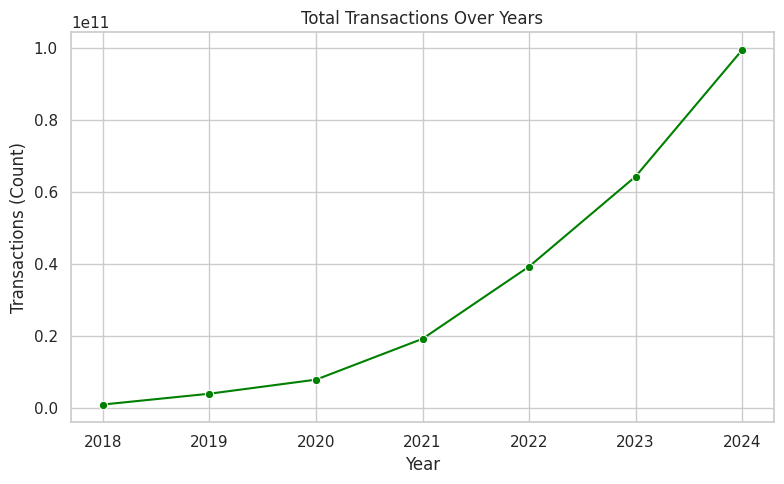

In [28]:
# Line Plot – Total Transactions per Year
plt.figure(figsize=(8,5))
sns.lineplot(data=yearly_trend, x="year", y="total_transactions", marker="o", color="green")
plt.title("Total Transactions Over Years")
plt.xlabel("Year")
plt.ylabel("Transactions (Count)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Parse aggregated user data
user_path = "pulse/data/aggregated/user/country/india/state/"
user_records = []

for state in os.listdir(user_path):
    for year in os.listdir(os.path.join(user_path, state)):
        for qf in os.listdir(os.path.join(user_path, state, year)):
            with open(os.path.join(user_path, state, year, qf)) as f:
                try:
                    content = json.load(f)["data"]["usersByDevice"]
                    for item in content:
                        user_records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "brand": item["brand"],
                            "count": item["count"],
                            "percentage": item["percentage"]
                        })
                except:
                    pass

# Create DataFrame and store in SQL
df_user = pd.DataFrame(user_records)
df_user.to_sql("aggregated_user", conn, if_exists="replace", index=False)

# Preview
df_user.head()


,state,year,quarter,brand,count,percentage
0,Lakshadweep,2018,3,Xiaomi,195,0.212418
1,Lakshadweep,2018,3,Samsung,166,0.180828
2,Lakshadweep,2018,3,Vivo,134,0.145969
3,Lakshadweep,2018,3,Oppo,121,0.131808
4,Lakshadweep,2018,3,Apple,46,0.050109


In [30]:
# Parse map transaction data at state level
map_path = "pulse/data/map/transaction/hover/country/india/state/"
map_records = []

for state in os.listdir(map_path):
    for year in os.listdir(os.path.join(map_path, state)):
        for qf in os.listdir(os.path.join(map_path, state, year)):
            with open(os.path.join(map_path, state, year, qf)) as f:
                try:
                    content = json.load(f)["data"]["hoverDataList"]
                    for item in content:
                        map_records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "district": item["name"],
                            "count": item["metric"][0]["count"],
                            "amount": item["metric"][0]["amount"]
                        })
                except:
                    pass

# Create DataFrame and store in SQL
df_map = pd.DataFrame(map_records)
df_map.to_sql("map_transaction", conn, if_exists="replace", index=False)

# Preview
df_map.head()


,state,year,quarter,district,count,amount
0,Lakshadweep,2023,3,lakshadweep district,43757,9.452706e+07
1,Lakshadweep,2023,2,lakshadweep district,34918,9.798744e+07
2,Lakshadweep,2023,1,lakshadweep district,29520,8.532196e+07
3,Lakshadweep,2023,4,lakshadweep district,63479,1.198314e+08
4,Lakshadweep,2018,3,lakshadweep district,1703,4.339032e+06


In [31]:
# Save extracted data to CSV for future use (e.g., Streamlit dashboard)
df_txn.to_csv("state_transaction_data.csv", index=False)
df_user.to_csv("state_user_device_data.csv", index=False)
df_map.to_csv("district_transaction_data.csv", index=False)

print("✅ All CSV files saved successfully.")


✅ All CSV files saved successfully.


In [32]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the existing SQLite database
conn = sqlite3.connect("phonepe_pulse.db")



In [33]:
# SQL Query: Top 5 districts by transaction amount
query_districts = """
SELECT district, SUM(amount) AS total_amount
FROM map_transaction
GROUP BY district
ORDER BY total_amount DESC
LIMIT 5;
"""

# Execute and load results into DataFrame
top_districts = pd.read_sql(query_districts, conn)
top_districts


,district,total_amount
0,bengaluru urban district,1.993784e+13
1,hyderabad district,1.190694e+13
2,pune district,9.730218e+12
3,jaipur district,7.854092e+12
4,rangareddy district,7.155140e+12


/tmp/ipython-input-34-1393375156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_districts, x='total_amount', y='district', palette='rocket')


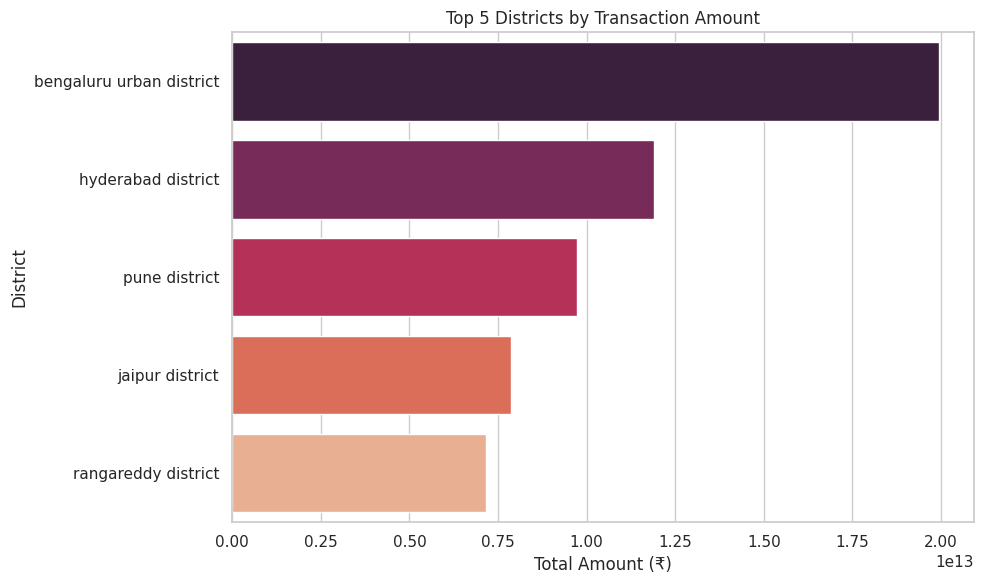

In [34]:
# Bar chart for top districts
plt.figure(figsize=(10, 6))
sns.barplot(data=top_districts, x='total_amount', y='district', palette='rocket')
plt.title("Top 5 Districts by Transaction Amount")
plt.xlabel("Total Amount (₹)")
plt.ylabel("District")
plt.tight_layout()
plt.show()


In [35]:
# SQL Query: Device brand trends over time
query_brands = """
SELECT year, brand, SUM(count) AS total_users
FROM aggregated_user
GROUP BY year, brand
ORDER BY year;
"""

# Execute and load into DataFrame
brand_trends = pd.read_sql(query_brands, conn)
brand_trends.head()


,year,brand,total_users
0,2018,Apple,9971798
1,2018,Asus,430392
2,2018,COOLPAD,10
3,2018,Gionee,723312
4,2018,Huawei,4287646


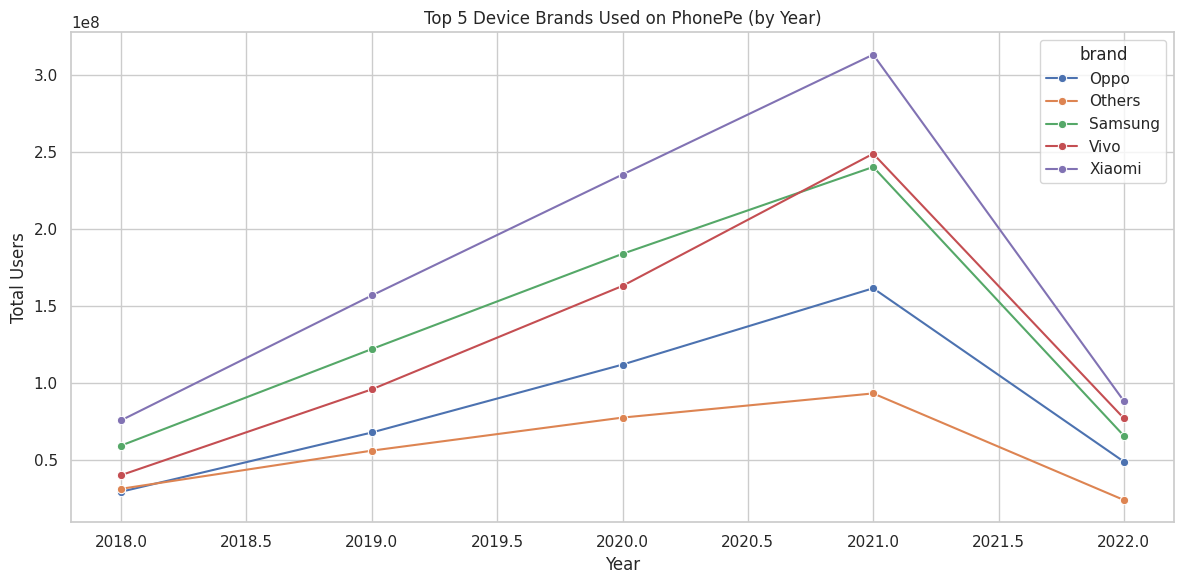

In [36]:
# Line plot for top 5 brands over time
top_brands = brand_trends.groupby("brand")["total_users"].sum().sort_values(ascending=False).head(5).index
filtered_brands = brand_trends[brand_trends["brand"].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_brands, x="year", y="total_users", hue="brand", marker="o")
plt.title("Top 5 Device Brands Used on PhonePe (by Year)")
plt.xlabel("Year")
plt.ylabel("Total Users")
plt.grid(True)
plt.tight_layout()
plt.show()
